In [229]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import datetime as dt
import calendar
import re
import warnings
import ticktock

%matplotlib inline

# Winter Quarter 2018

See Fall-Quarter-2017 for an explanation for why this exists. This is a quick-and-dirty treatment of similar Winter Quarter data.

# Gettin' Started

In [230]:
data_path = "./Winter-2018-Data/"
general = pd.read_csv(data_path + "general.csv", skiprows=1,
                      names=["Event", "Start_time", "End_time"])

In [231]:
general = ticktock.convert_columns(general)

quarter_start = "01/08/2018"
quarter_end = "03/23/2018"

general = ticktock.filter_by_date(general, quarter_start, quarter_end)
general.shape

(152, 3)

In [232]:
general.is_copy = False
general['total_time'] = general.apply(lambda x: ticktock.total_time(x), axis=1)

# Study Analysis

In [233]:
subjects = ["MATH 164", "STATS 100B", "STATS 102A"]
total_times = []

In [234]:
general.is_copy = False

for i, subject in enumerate(subjects):
    study_subject = general.apply(lambda x: ticktock.is_studying(x['Event'], subject), axis=1)
    general['Studying {}'.format(subject)] = study_subject
    
    total_hours = general.loc[general['Studying {}'.format(subject)], 'total_time'].sum()
    total_times.append(total_hours)
    print("Total time studying {}: {}".format(subject, total_hours))
    
print("Total time studying all subjects: {}".format(sum(total_times)))

Total time studying MATH 164: 61.0
Total time studying STATS 100B: 99.5
Total time studying STATS 102A: 39.5
Total time studying all subjects: 200.0


Looks like I spent more time studying this quarter than I did last quarter (172 hours in Fall Quarter). 

In [235]:
# set matplotlib parameters
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-darkgrid')

tropical_colors = ["#3D84A8", "#FF7E67", "#FFB400"]

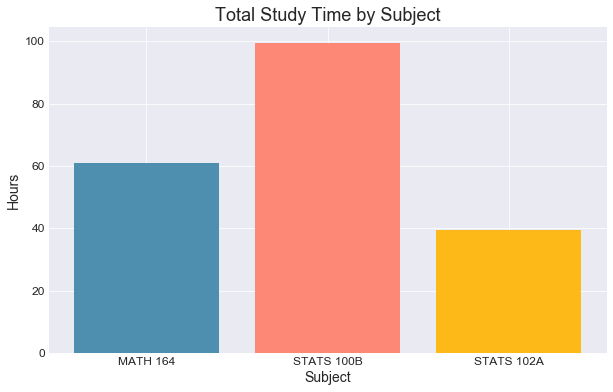

In [236]:
fig, ax = ticktock.create_plot(figsize=(10, 6), title="Total Study Time by Subject", 
                               xlabel="Subject", ylabel="Hours")

g = ax.bar(subjects, total_times, color=tropical_colors, alpha=0.9)

plt.show()

And the winner is...STATS 100B! (Surprise, surprise)

In [237]:
# change index to day of event
general = general.set_index(['Start_time'])
general.index = general.index.date

## Studying Trends

In [238]:
math_164_data = general.loc[general['Studying MATH 164'], :]
stats_100b_data = general.loc[general['Studying STATS 100B'], :]
stats_102a_data = general.loc[general['Studying STATS 102A'], :]
all_studying_data = general.loc[(general['Studying MATH 164'] | \
                                 general['Studying STATS 100B'] | general['Studying STATS 102A']), :]

math_164_by_day = math_164_data.groupby(math_164_data.index).sum()
stats_100b_by_day = stats_100b_data.groupby(stats_100b_data.index).sum()
stats_102a_by_day = stats_102a_data.groupby(stats_102a_data.index).sum()
all_studying_data = all_studying_data.groupby(all_studying_data.index).sum()

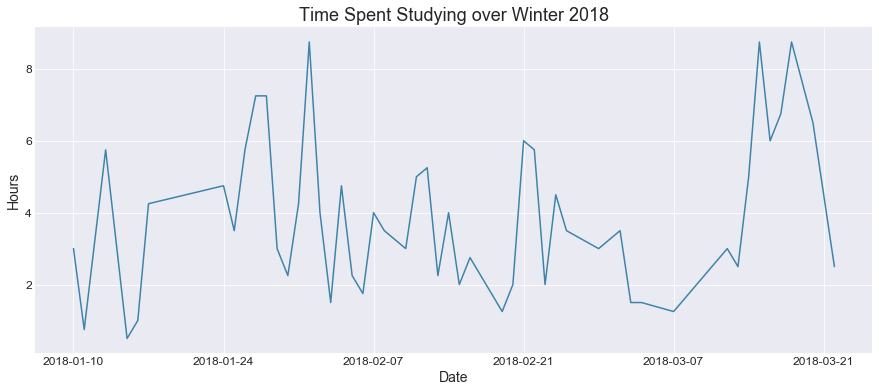

In [239]:
fig, ax = ticktock.create_plot(title="Time Spent Studying over Winter 2018", ylabel="Hours", xlabel="Date")

ax.plot(all_studying_data['total_time'], color=tropical_colors[0]);

plt.show()

### Breaking it down by subject

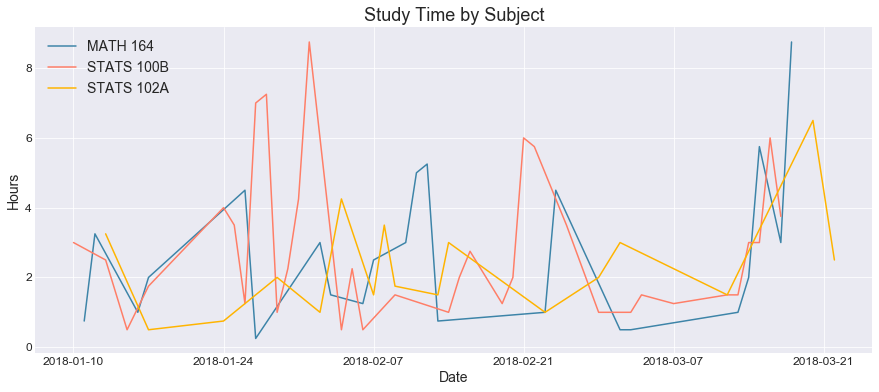

In [240]:
fig, ax = ticktock.create_plot(title="Study Time by Subject", xlabel="Date", ylabel="Hours")

for i, ts in enumerate([math_164_by_day, stats_100b_by_day, stats_102a_by_day]):
    ax.plot(ts['total_time'], color=tropical_colors[i])
    
ax.legend(subjects)

plt.show()

### Week-by-Week Analysis

In [241]:
math_164_by_week = ticktock.group_by_week(math_164_data, quarter_start, "sum")
stats_100b_by_week = ticktock.group_by_week(stats_100b_data, quarter_start, "sum")
stats_102a_by_week = ticktock.group_by_week(stats_102a_data, quarter_start, "sum")
all_studying_by_week = ticktock.group_by_week(all_studying_data, quarter_start, "sum")

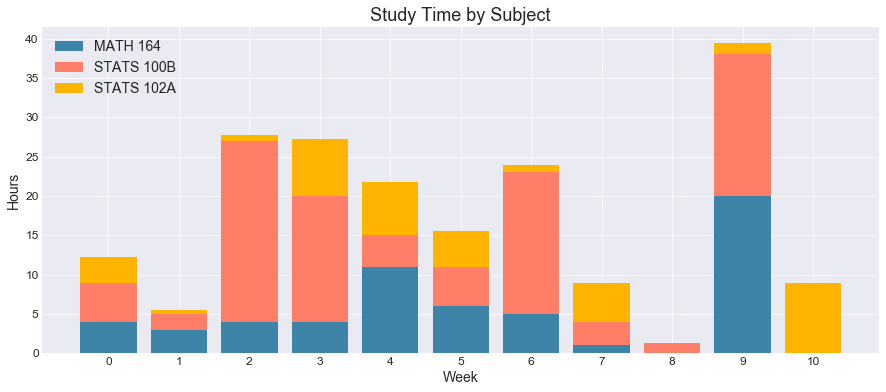

In [242]:
fig, ax = ticktock.create_plot(title="Study Time by Subject", xlabel="Week", ylabel="Hours")

floor = pd.Series(0, index=range(12)) # where the next bar chart should start
    
for i, subject in enumerate([math_164_by_week, stats_100b_by_week, stats_102a_by_week]):
    ax.bar(x=subject.index , height=subject['total_time'], linewidth=0, 
           bottom=floor[subject.index], color=tropical_colors[i]);
    for i in subject.index: 
        floor[i] += subject.loc[i]['total_time'] # gotta do it this way to avoid NaNs

ax.legend(subjects)
ax.set_xticks(all_studying_by_week.index )

plt.show()

Week 9's looking a 'lil sad there. ORCS (Opening Round Championship Series) was at the end of week 9, and ORCS is basically the most important tournament we have in mock trial for all of Winter quarter. I definitely spent a lot of time at practice week 8 and week 9, which would explain the dip in studying.

# Workouts

In [243]:
all_workouts = pd.read_csv(data_path + "exercise.csv", skiprows=1, 
                           names=["Event", "Start_time", "End_time"])

all_workouts = ticktock.convert_columns(all_workouts)
workouts = ticktock.filter_by_date(all_workouts, quarter_start, quarter_end)

workouts.shape

(29, 3)

In [244]:
workouts.is_copy = False # avoid SettingWithCopyWarning

workouts['total_time'] = workouts.apply(lambda x: ticktock.total_time(x), axis=1)

run = workouts.apply(lambda x: ticktock.is_workout(x['Event'], "run"), axis=1)
workouts['Run'] = run

run_length = workouts.apply(lambda x: ticktock.run_length(x['Event']), axis=1)
workouts['Run_length'] = run_length

workouts = workouts.set_index(['Start_time']) # change index to date
workouts.index = workouts.index.date
workouts = workouts.drop(columns=['End_time'])
workouts.tail()

,Event,total_time,Run,Run_length
2018-03-12,5 mile run,1.0,True,5.0
2018-03-14,5 mile run,1.0,True,5.0
2018-03-15,5 mile run,1.0,True,5.0
2018-03-20,5 mile run,1.0,True,5.0
2018-03-20,5 mile run,1.0,True,5.0


In [245]:
workouts_by_week = ticktock.group_by_week(workouts, quarter_start, "size") # holds counts

workout_time_by_week = ticktock.group_by_week(workouts, quarter_start, "sum")

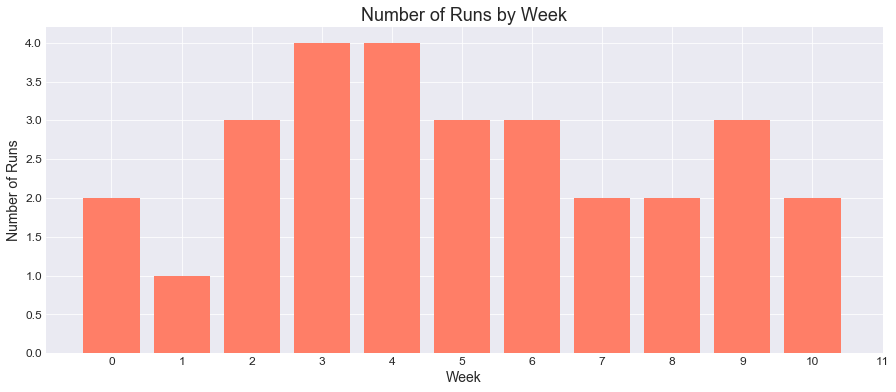

In [246]:
fig, ax = ticktock.create_plot(title="Number of Runs by Week", xlabel="Week",
                               ylabel="Number of Runs")

ax.bar(x=workouts_by_week.index , height=workouts_by_week, color=tropical_colors[1]);
ax.set_xticks(range(12))

plt.show()

In [247]:
miles_by_week = ticktock.group_by_week(workouts['Run_length'], quarter_start, "sum")

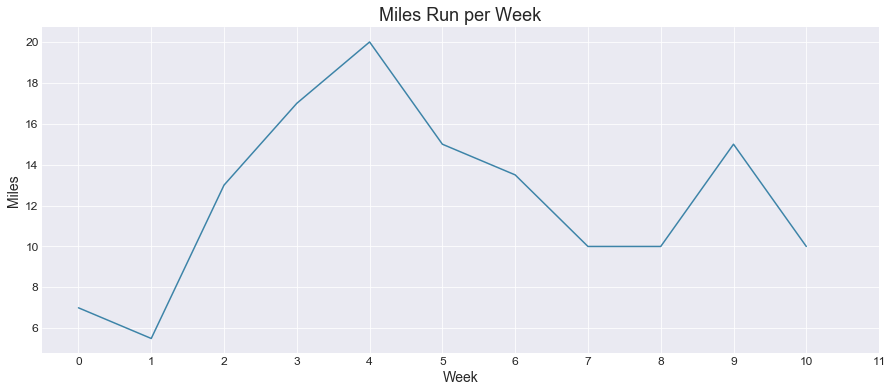

In [248]:
fig, ax = ticktock.create_plot(title="Miles Run per Week", xlabel="Week", ylabel="Miles")

ax.plot(miles_by_week, color=tropical_colors[0]);
ax.set_xticks(range(12))

plt.show()

# Social

In [249]:
all_social = pd.read_csv(data_path + "social.csv", skiprows=1,
                     names=["Event", "Start_time", "End_time"])

all_social = ticktock.convert_columns(all_social)
social = ticktock.filter_by_date(all_social, quarter_start, quarter_end)

social.is_copy = False # avoid SettingWithCopyWarning
social['total_time'] = social.apply(lambda x: ticktock.total_time(x), axis=1)

social = social.set_index(['Start_time']) # change index to date
social.index = social.index.date
social = social.drop(columns=['End_time'])

### Mock those trials

In [250]:
social['is_mock'] = social.apply(lambda x: ticktock.is_mock_related(x['Event']), axis=1)

In [251]:
social[social['Event'].str.contains("Tournament|ORCS|Invitational|Regionals")]

,Event,total_time,is_mock
2018-01-13,UCLASSIC Tournament,48.0,True
2018-01-18,Downtown Invitational,120.0,True
2018-02-17,Tempe Regionals,48.0,True
2018-03-10,ORCS,48.0,True


I went to four tournaments this quarter. Since these tournaments are multi-day events, they're a lot longer than any other of the events in the social data. I'm gonna go ahead and code each of these tournaments as 15 hours for each day the tournament runs.

In [252]:
social['is_tournament'] = social.apply(lambda x: ticktock.is_tournament(x['Event']), axis=1)

social.loc[social['is_tournament'], 'total_time'] = (social.loc[social['is_tournament'], 'total_time'] / 24) * 15


In [253]:
social_by_week = ticktock.group_by_week(social, quarter_start, 'sum')

mock_data = social[social['is_mock']]
mock_by_week = ticktock.group_by_week(mock_data, quarter_start, "sum")

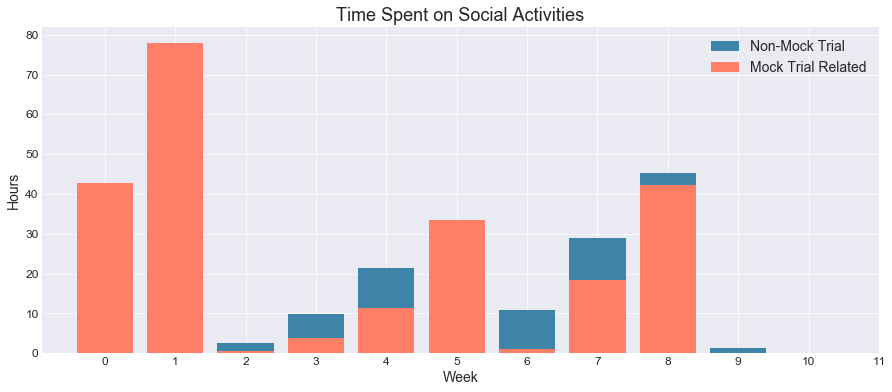

In [254]:
fig, ax = ticktock.create_plot(title="Time Spent on Social Activities",
                               xlabel="Week", ylabel="Hours")

ax.bar(social_by_week.index , social_by_week['total_time'], color=tropical_colors[0])
ax.bar(mock_by_week.index , mock_by_week['total_time'], color=tropical_colors[1])

ax.legend(["Non-Mock Trial", "Mock Trial Related"])
ax.set_xticks(range(12))

plt.show()

*Hahahahaha*

# Work

In [255]:
all_work = pd.read_csv(data_path + "work.csv", skiprows=1,
                       names=["Event", "Start_time", "End_time"])

all_work = ticktock.convert_columns(all_work)
work = ticktock.filter_by_date(all_work, quarter_start, quarter_end)

work.is_copy = False # avoid SettingWithCopyWarning
work['total_time'] = work.apply(lambda x: ticktock.total_time(x), axis=1)

work = work.set_index(['Start_time']) # change index to date
work.index = work.index.date
work = work.drop(columns=['End_time'])

In [256]:
work_by_week = ticktock.group_by_week(work, quarter_start, "sum")

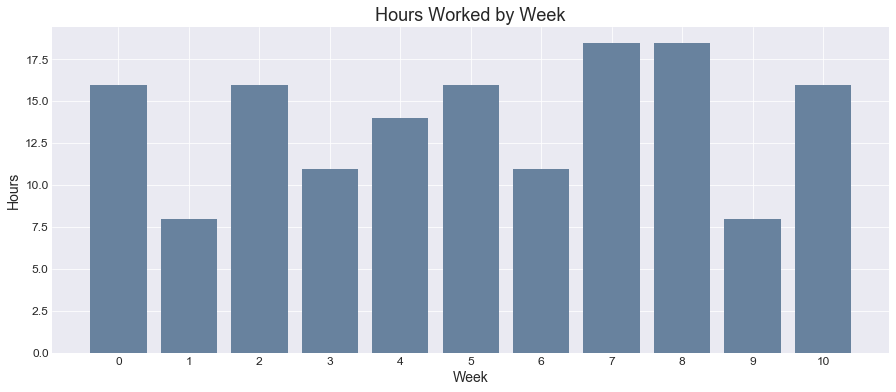

In [257]:
fig, ax = ticktock.create_plot(title="Hours Worked by Week", ylabel="Hours", xlabel="Week")

ax.bar(work_by_week.index, work_by_week['total_time'], color="#68829E")
ax.set_xticks(work_by_week.index)

plt.show()

# The big question

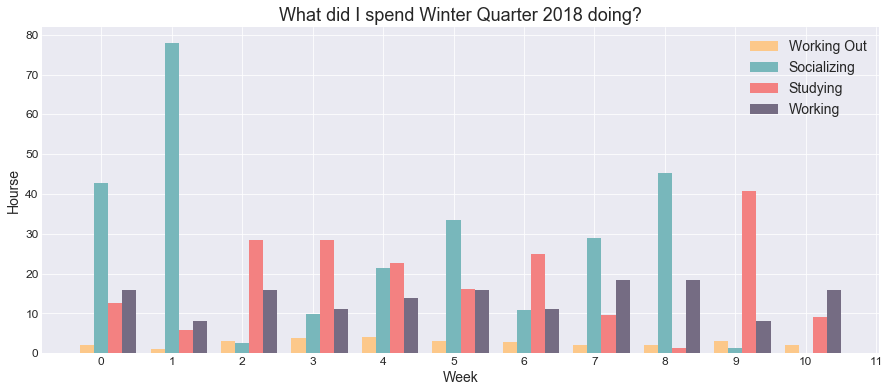

In [258]:
fig, ax = ticktock.create_plot(title="What did I spend Winter Quarter 2018 doing?", 
                      xlabel="Week", ylabel="Hourse")

categories = [workout_time_by_week, social_by_week, all_studying_by_week, work_by_week]
bar_colors = np.array(["#FCC88A", "#78B7BB", "#F38181", "#756C83"])

for i, category in enumerate(categories):
    ax.bar(x=category.index-0.2 + i*0.2, height=category['total_time'], width=0.2, 
           color=bar_colors[i])

ax.legend(['Working Out', 'Socializing', 'Studying', 'Working'])
ax.set_xticks(range(12))

plt.show()